In [6]:
import sys
import os

sys.path.append('scripts')

import re
import json
import argparse
import itertools
from pathlib import Path
import collections
import math
from dataclasses import dataclass,asdict, astuple
from concurrent.futures import ProcessPoolExecutor

import numpy as np
import matplotlib.pyplot as plt
# from matplotlib.font_manager import FontProperties
import matplotlib.font_manager as fm
from matplotlib.patches import FancyBboxPatch
from matplotlib.patches import PathPatch
from matplotlib.path import get_path_collection_extents
import seaborn as sns

from rich import print, pretty
from typing import  Iterable, List
import pretty_errors
from catppuccin import PALETTE

from utils import *
from ldj import ldj

pretty.install()

RESULT_DIR: Path = Path("../experiments/schedules")

assert RESULT_DIR.is_dir() and RESULT_DIR.exists()

flavor = PALETTE.latte.colors
# num-robots-10-seed-0.json
# experiments/schedules/schedule-centered-internal-50-external-5-seed-0.json
# RE = re.compile(r"schedule-(\w-)-internal-(\d+)-external-(\d+)-seed-(\d+).json")
RE = re.compile(r'schedule-([\w-]+)-internal-(\d+)-external-(\d+)-seed-(\d+)\.json')


# use LaTeX for text with matplotlib
sns.set_style("darkgrid")
# set background color of sns darkgrid to flavor.base.hex
plt.rcParams['axes.facecolor'] = flavor.base.hex
# set font color to flavor.text.hex
plt.rcParams['text.color'] = flavor.text.hex

font_dirs = ["./fonts/"]
# go through all fonts in the font directory and add them
for font_dir in font_dirs:
    for font in os.listdir(font_dir):
        fm.fontManager.addfont(f"{font_dir}/{font}")

prop_jbm = fm.FontProperties(fname='./fonts/JetBrainsMonoNerdFontMono-Regular.ttf')
prop = fm.FontProperties(fname='./fonts/STIXTwoText-VariableFont_wght.ttf')

plt.rcParams.update({
    # "text.usetex": True,
    "font.family": prop.get_name(),
    # "font.family": "stix",
    # "font.sans-serif": prop.get_name(),
    "mathtext.fontset": "stix",
    # "text.latex.preamble": r"\usepackage{fontenc}\usepackage{fontspec}\setmainfont{JetBrainsMonoNerdFontMono-Regular}",
})


colors = [
    (flavor.lavender.hex, 1.0, (1, 0), 'o'),
    (flavor.yellow.hex, 0.3, (2, 2), 'X'),
    (flavor.peach.hex, 0.3, (2, 2), 'X'),
    (flavor.green.hex, 1.0, (2, 2), '^')
]


In [8]:

def flatten(lst: Iterable) -> list:
    return list(itertools.chain.from_iterable(lst))


@dataclass(frozen=True)
class ExperimentParams:
    schedule: str
    internal: int
    external: int
    seed: int

@dataclass
class ProcessedData:
    distance_travelled: list[float]
    finished_at: list[float]
    ldj: list[float]
    makespan: float
    robot_collisions: int
    params: ExperimentParams


def process_file(file) -> ProcessedData:
    print(f"{file.name=}")
    match = RE.match(file.name)
    assert match is not None
    schedule = str(match.group(1))
    internal = int(match.group(2))
    external = int(match.group(3))
    seed = int(match.group(4))

    with open(file, 'r') as file:
        data = json.load(file)

    distance_travelled_of_each_robot: list[float] = []
    finished_at_of_each_robot: list[float] = []
    ldj_of_each_robot: list[float] = []
    robot_collisions: int = len(data['collisions']['robots'])
    environment_collisions: int = len(data['collisions']['environment'])

    for _, robot_data in data['robots'].items():
        positions = np.array(robot_data['positions'])
        distance_travelled: float = np.sum(np.linalg.norm(np.diff(positions, axis=0), axis=1))
        distance_travelled_of_each_robot.append(distance_travelled)

        mission = robot_data['mission']
        # robot_collisions += robot_data['collisions']['robots']

        started_at: float = mission['started_at']
        finished_at: float = mission['finished_at'] if mission['finished_at'] else mission['duration'] + started_at
        finished_at_of_each_robot.append(finished_at)

        timestamps: np.ndarray = np.array([measurement['timestamp'] for measurement in robot_data['velocities']])
        velocities3d_bevy: np.ndarray = np.array([measurement['velocity'] for measurement in robot_data['velocities']])
        velocities = velocities3d_bevy[:, [0, 2]]

        ldj_metric = ldj(velocities, timestamps)
        ldj_of_each_robot.append(ldj_metric)

    makespan: float = data['makespan']

    params = ExperimentParams(
        internal=internal,
        external=external,
        seed=seed,
        schedule=schedule
    )

    return ProcessedData(
        distance_travelled=distance_travelled_of_each_robot,
        finished_at=finished_at_of_each_robot,
        ldj=ldj_of_each_robot,
        robot_collisions=robot_collisions,
        makespan=makespan,
        params=params
    )


In [4]:
processed_data: list[ProcessedData] = []
with ProcessPoolExecutor() as executor:
    results = executor.map(process_file, RESULT_DIR.glob('*.json'))


processed_data = [data for data in results]

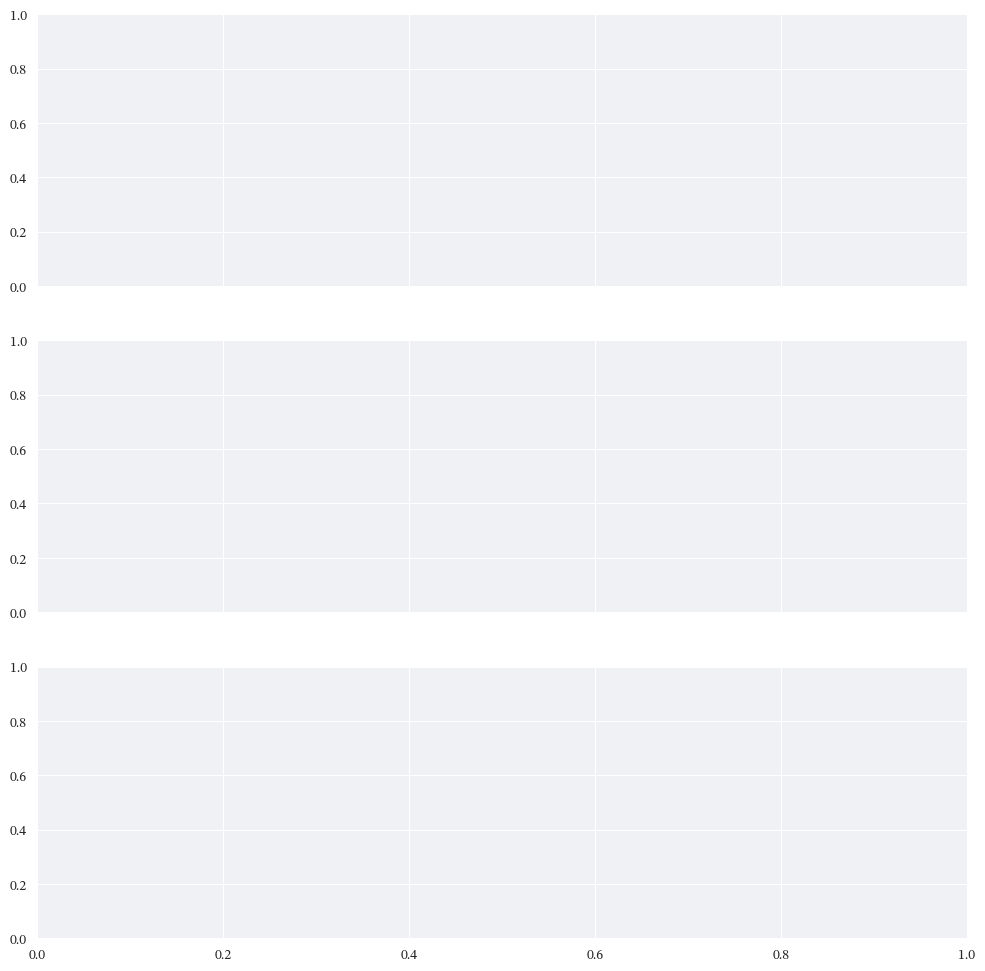

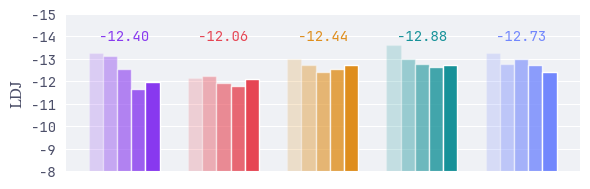

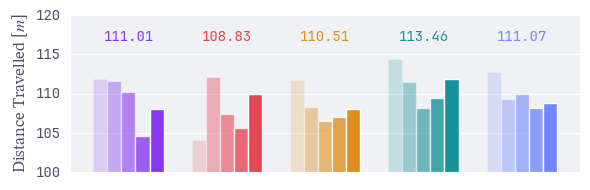

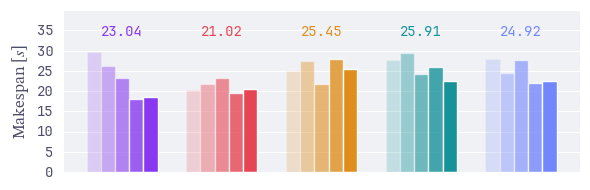

In [15]:
# Group data by schedule type and external value
grouped_data = {}
for data in processed_data:
    key = (data.params.schedule, data.params.external)
    if key not in grouped_data:
        grouped_data[key] = {'ldj': [], 'distance_travelled': [], 'makespan': [], 'robot_collisions': []}
    grouped_data[key]['ldj'].extend(data.ldj)
    grouped_data[key]['distance_travelled'].extend(data.distance_travelled)
    grouped_data[key]['makespan'].append(data.makespan)
    # grouped_data[key]['robot_collisions'].append(data.robot_collisions)

# Schedule types and external values
schedule_types = sorted(set(data.params.schedule for data in processed_data))
external_values = sorted(set(data.params.external for data in processed_data))

# Plotting
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

bar_width = 0.15
group_width = bar_width * len(external_values) + 0.3
index = np.arange(len(schedule_types)) * group_width
opacity = 0.8

nbars_per_group: int = len(external_values)
center_bar_index: int = math.ceil(nbars_per_group / 2)

metrics = ['ldj', 'distance_travelled', 'makespan']
titles = ['LDJ Metric Value', 'Distance Travelled', 'Makespan']
y_labels = ['LDJ', 'Distance Travelled [$m$]', 'Makespan [$s$]']

# Custom y-axis limits to make differences more pronounced
y_limits = [(-15, -8), (100, 120), (0, 40), (0, 10)]

# Colors for different external values
base_colors = [flavor.mauve.hex, flavor.maroon.hex, flavor.yellow.hex, flavor.teal.hex, flavor.lavender.hex]

# for ax, metric, title, ylabel, y_limit in zip(axes, metrics, titles, y_labels, y_limits):
for  metric, title, ylabel, y_limit in zip( metrics, titles, y_labels, y_limits):
    fig, ax = plt.subplots(figsize=(6, 2))
    
    for j, schedule_type in enumerate(schedule_types):
        # print(f"{schedule_type=}")
        for i, external_value in enumerate(external_values):
            # metric_values = np.mean(grouped_data[(schedule_type, external_value)][metric])
            metric_values = np.median(grouped_data[(schedule_type, external_value)][metric])
            bar_positions = index[j] + i * bar_width
            color = base_colors[j % len(base_colors)]
            alpha_value = 0.2 + (i * 0.2)
            ax.bar(bar_positions, metric_values, bar_width, alpha=alpha_value, color=color, label=f'External {external_value}' if i == 0 else "")
    # ax.set_ylabel(ylabel)
    ax.set_ylabel(ylabel, fontsize=12, fontdict={'color': flavor.text.hex})

    # ax.set_title(title)
    ax.set_ylim(y_limit)
    # ax.legend()
    match metric:
        case 'ldj':
            # yticks = np.arange(-14, -6, -1)
            yticks = np.arange(-8, -16, -1)
            ax.set_yticks(yticks)
            ax.set_yticklabels(yticks, fontproperties=prop_jbm, fontdict=dict(color=flavor.text.hex))
            # pass
        case 'distance_travelled':
            # yticks = np.arange(100, 122.5, 2.5)
            yticks = np.arange(100, 125, 5)
            ax.set_yticks(yticks)
            ax.set_yticklabels(yticks, fontproperties=prop_jbm, fontdict=dict(color=flavor.text.hex))
            # pass
        case 'makespan':
            yticks = np.arange(0, 40, 5)
            ax.set_yticks(yticks)
            ax.set_yticklabels(yticks, fontproperties=prop_jbm, fontdict=dict(color=flavor.text.hex))
            # pass

    if metric == 'ldj':
        ax.invert_yaxis()  # Invert y-axis for LDJ metric

    # Annotate mean values below each group
    for j, schedule_type in enumerate(schedule_types):
        aggregated_value = np.mean([np.mean(grouped_data[(schedule_type, external_value)][metric]) for external_value in external_values])

        x = index[j] + (group_width - bar_width  * center_bar_index) / 2
        y = y_limit[0] - (y_limit[0] - y_limit[1]) * 0.90
        if metric == 'ldj':
            y = y_limit[1] - (y_limit[1] - y_limit[0]) * 0.90

        color = base_colors[j % len(base_colors)]
        ax.text(x, y, f'{aggregated_value:.2f}', ha='center', va='top', fontproperties=prop_jbm, fontdict=dict(color=color))
    
    ax.set_xticks([])

    output = Path(f"schedules-{metric}.svg")
    fig.patch.set_facecolor((0, 0, 0, 0))
    # Draw optimal line
    # ax.axhline(y=100, color=flavor.overlay2.hex, linestyle='--', linewidth=1.5)

    fig.tight_layout()
    fig.savefig(output)